# `Самообучение: Подсчёт примитивов (counting visual primitives)`

### *Основная идея:* разбить изображение на части, и обучить модель строить признаки (примитивы) так, чтобы сумма признаков частей изображения была близка к признакам исходного изображения и далека от признаков другого рандомного изображения
Подход более подробно раскрыт в статье: [Representation Learning by Learning to Count](https://arxiv.org/pdf/1708.06734.pdf) 

In [65]:
import os
import numpy as np
from torchvision import transforms
import torch, torchvision
import PIL
import cv2 as cv
import warnings
from typing import List
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib_inline
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

## `ImageNet`

Будем использовать [Tiny ImageNet Dataset](https://paperswithcode.com/dataset/tiny-imagenet). Этот датасет состоит из исходного датасета ImageNet, у которого оставили 200 классов и усреднили разрешение картинок до 64x64 &ndash; он гораздо компактнее и с ним удобнее работать.

У датасета 100К тренировочных данных, и по 10К валидационных и тестовых.

In [2]:
! wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2023-06-17 00:25:39--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  7.58MB/s    in 19s     

2023-06-17 00:25:58 (12.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
import zipfile
with zipfile.ZipFile("/content/tiny-imagenet-200.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ])
}

data_dir = './tiny-imagenet-200/'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

In [5]:
print("Dataset size:", {x: len(image_datasets[x]) for x in ["train", "val", "test"]})

Dataset size: {'train': 100000, 'val': 10000, 'test': 10000}


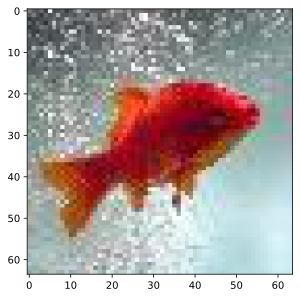

In [6]:
plt.imshow(image_datasets["train"][2][0].permute(1, 2, 0))
plt.show()

Каждую картинку (из датасета, не обрезанную) будем ужимать в 2 раза до разрешения 32x32, чтобы исходные картинки были такими же по величине как их части (ужимаем до 32x32 потому что разбиваем картинки на 4 части)

Для каждой картинки, будем выбирать один случайный объект из остального датасета, не равному исходной картинке

In [7]:
class CountPrimitDataset:
    def __init__(self, image_dataset):
        assert len(image_dataset) > 1
        self.image_dataset = image_dataset
        self.dsize = (32, 32)

    def __getitem__(self, index):
        outsider_idx = index
        while outsider_idx == index:
            outsider_idx = np.random.randint(0, len(self.image_dataset))
        outsider = self.image_dataset[outsider_idx][0]
        image = self.image_dataset[index][0]
        msize1, msize2 = self.dsize[0], self.dsize[1]
        return {
            "outsider": torch.from_numpy(cv.resize(outsider.numpy().transpose(1, 2, 0), dsize=self.dsize, interpolation=cv.INTER_CUBIC).transpose(2, 0, 1)),
            "parts": torch.stack([image[:, :msize1, :msize2], image[:, msize1:, :msize2],
                                  image[:, :msize1, msize2:], image[:, msize1:, msize2:]]),
            "image": torch.from_numpy(cv.resize(image.numpy().transpose(1, 2, 0), dsize=self.dsize, interpolation=cv.INTER_CUBIC).transpose(2, 0, 1))
        }

    def __len__(self):
        return len(self.image_dataset)

In [8]:
countprim_ds = CountPrimitDataset(image_datasets["train"])

Конечно мы могли бы провести аугментацию, но данных уже довольно много, будет затруднительно на всём этом обучиться

In [9]:
print(len(countprim_ds))
item = countprim_ds[2]
print("outsider shape:", item["outsider"].shape)
print("parts shape:", item["parts"].shape)
print("image shape:", item["image"].shape)

100000
outsider shape: torch.Size([3, 32, 32])
parts shape: torch.Size([4, 3, 32, 32])
image shape: torch.Size([3, 32, 32])


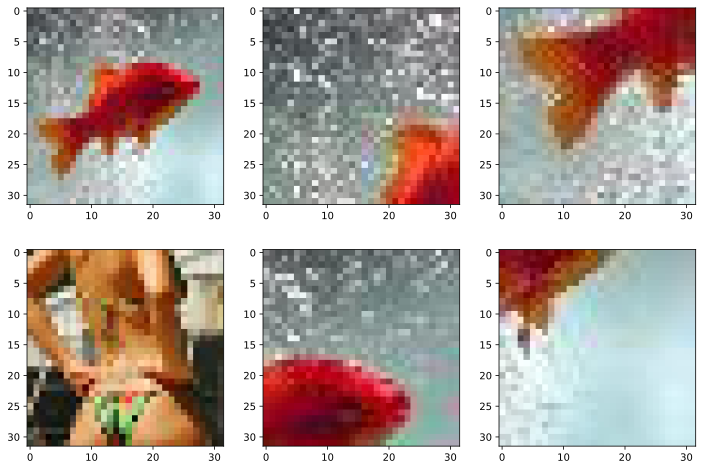

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0, 0].imshow(item["image"].permute(1, 2, 0))
axes[1, 0].imshow(item["outsider"].permute(1, 2, 0))
for i, part in enumerate(item["parts"]):
    axes[i // 2, 1 + i % 2].imshow(part.permute(1, 2, 0))

plt.show()

Как видно на примере, мы взяли части исходного изображения рыбки, затем выбрали рандомное изображение и сжали его, заодно мы сжали изображение рыбки и теперь все изображения имеют размерность 32x32

In [11]:
def collate_fn(batch: List[dict[str, torch.Tensor]]) -> dict[str, torch.Tensor]:
    '''
    :param List[dict[str, torch.tensor]] batch: List of samples from CountPrimitDataset
    :return: Dictionary of tensors: {
            'outsider': torch.Tensor,       # size (batch_size, C, M, N)
            'parts': torch.Tensor,          # size (batch_size, n_parts, C, M, N)
            'image': torch.Tensor           # size (batch_size, C, M, N)
        }
    :rtype: Dict[str, torch.Tensor]
    '''
    return {
        "outsider": torch.stack([t["outsider"] for t in batch]),
        "parts": torch.stack([t["parts"] for t in batch]),
        "image": torch.stack([t["image"] for t in batch])
    }

In [12]:
batch_size = 8
countprim_dl = DataLoader(countprim_ds, batch_size, shuffle=True, collate_fn=collate_fn)
print("Dataloader size:", len(countprim_dl))

Dataloader size: 12500


In [13]:
batch = next(iter(countprim_dl))
batch["outsider"].shape, batch["parts"].shape, batch["image"].shape

(torch.Size([8, 3, 32, 32]),
 torch.Size([8, 4, 3, 32, 32]),
 torch.Size([8, 3, 32, 32]))

## `Solution architecture`

AlexNet не подходит для изображений размера 32x32 (сжимает всё в вектор 1x1), поэтому немного поменяем её архитектуру

В статье на вход AlexNet подавались изображения 114x114, а у нас 32x32. Архитектура AlexNet не позволяет изображению с таким размером пройти forward pass. Чтобы у нас нормально обрабатывались изображения размера 32x32 немного поменяем структуру: уберём один max pooling, сделаем поменьше размерности ядра где возможно -- в целом ничего особо не меняется глобально. 

Теперь, модифицируем структуру нормализацией. Дело в том, что у исходных изображений разбросана интенсивность и их следует нормализовать. Можно было это сделать вычислив среднее и дисперсию по всем каналам всех изображений, однако хорошим решением оказывается просто добавить первым слоем в сети *batch normalization* -- это позволило сети гораздо быстрее обучаться. Также был добавлен batch norm и в другие места архитектуры, в основном после ReLU -- это добавило сети ещё скорости обучения и регуляризации. Последние fc-слои я взял без изменения как в статье.

В обучении модели также присутствует константа M, которую рекомендуют брать равной 10. Я оставил её такой же как в рекомендации. Однако возникает проблема, что когда рандомно выбранное изображение слишком не похоже на исходное, то max(0, ...) в итоговой Loss-функции становится константно-нулевым, а значит модель совсем не обучается по нему. Поэтому вместо этого я использовал ELU (Exponential Linear Unit), чтобы модель продолжала обучаться даже на отрицательных значениях, а не резко обрывалась в обучении.

In [88]:
class alexnetPrimitive(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.batchnorm1 = torch.nn.BatchNorm2d(3)
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            torch.nn.Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(96),
            torch.nn.Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(192),
            torch.nn.Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(3, 3))
        self.primitives = torch.nn.Sequential(
            torch.nn.Linear(in_features=3 * 3 * 128, out_features=2048),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features=2048, out_features=2048),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features=2048, out_features=1000),
            torch.nn.ReLU(inplace=True),
        )

        self.reset_parameters()

    def reset_parameters(self):
        with torch.no_grad():
            for module in self.features:
                if isinstance(module, torch.nn.Conv2d):
                    torch.nn.init.xavier_uniform_(module.weight.data)

    def forward(self, batch):
        batch = self.batchnorm1(batch)
        batch = self.features(batch)
        batch = self.avgpool(batch)
        batch = torch.flatten(batch, -3, -1)
        batch = self.primitives(batch)
        return batch

In [72]:
model = alexnetPrimitive()
batch_imgs = next(iter(countprim_dl))["image"]
model(batch_imgs).shape

torch.Size([8, 500])

In [73]:
class LossPrimitive(torch.nn.Module):
    def __init__(self, M=10):
        super().__init__()
        self.mse1 = torch.nn.MSELoss()
        self.mse2 = torch.nn.MSELoss()
        self.M = M

    def forward(self, outsider, parts, image):
        """batch: dict[str, torch.tensors],
        keys of batch are 'outsider' (batch_size, feature_size), 'parts' (4 * batch_size, feature_size), 'image' (batch_size, feature_size)"""
        sum_parts = torch.sum(parts.reshape(outsider.shape[0], 4, -1), dim=1)
        return torch.maximum(torch.tensor(0), self.M - self.mse1(outsider, sum_parts)) + self.mse2(image, sum_parts)


class LossPrimitive_Leaky(torch.nn.Module):
    def __init__(self, M=10, alpha=0.1):
        super().__init__()
        self.mse1 = torch.nn.MSELoss()
        self.mse2 = torch.nn.MSELoss()
        self.M = M
        self.elu = torch.nn.ELU(alpha=1)

    def forward(self, outsider, parts, image):
        """batch: dict[str, torch.tensors],
        keys of batch are 'outsider' (batch_size, feature_size), 'parts' (4 * batch_size, feature_size), 'image' (batch_size, feature_size)"""
        sum_parts = torch.sum(parts.reshape(outsider.shape[0], 4, -1), dim=1)
        return self.elu(self.M - self.mse1(outsider, sum_parts)) + self.mse2(image, sum_parts)

In [75]:
loss = LossPrimitive_Leaky()
loss(torch.rand(8, 500), torch.rand(8 * 4, 1000), torch.rand(8, 1000))

tensor(10.0159)

In [76]:
def train(n_epoch, model, train_dataloader, loss_fn, optimizer, scheduler, device):
    model.to(device)
    total_loss = []
    for epoch in tqdm(range(n_epoch), total=n_epoch):
        model.train()
        running_loss = 0
        n = 0
        for batch in (pbar := tqdm(train_dataloader, total=len(train_dataloader))):
            scheduler.step()
            optimizer.zero_grad()

            batch_size = batch["outsider"].shape[0]
            outsider = batch["outsider"]
            parts = batch["parts"]
            parts = parts.reshape(4 * batch_size, parts.shape[-3], parts.shape[-2], parts.shape[-1])
            image = batch["image"]
            x = torch.cat((outsider, parts, image)).to(device)
            outputs = model(x)
            outsider, parts, image = outputs[:batch_size], outputs[batch_size: 5 * batch_size], outputs[5 * batch_size:]
            loss = loss_fn(outsider, parts, image)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n += 1

            pbar.set_description(
                    "Loss: {}".format(running_loss / n)
            )
        total_loss.append(running_loss / len(train_dataloader))

    return total_loss


In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = alexnetPrimitive()
# loss_fn = LossPrimitive(M=10)
loss_fn = LossPrimitive_Leaky(M=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10_000, 0.9)
n_epoch = 3

device

device(type='cuda', index=0)

In [135]:
results = train(n_epoch, model, countprim_dl, loss_fn, optimizer, scheduler, device)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

Если bar'ы вдруг не отображаются, то мы достигли качества -0.24 -- то есть задача должно быть неплохо решена судя по лоссу

In [141]:
torch.save(model.state_dict(), "/content/model.pt")

## `Classification task`

После решения предварительной задачи, будем решать задачу классификации на ImageNet'е. Для этого воспользуемся полученными представлениям изображений после свёрток, и обучим на них линейный классификатор

In [17]:
print("num_classes:", np.unique([image_datasets["train"][i][1] for i in range(len(image_datasets["train"]))]).shape[0])

num_classes: 200


In [89]:
model = alexnetPrimitive()
model.load_state_dict(torch.load("/content/model.pt", map_location=torch.device("cpu")))
model.eval()

alexnetPrimitive(
  (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU

### `Dataset`

Здесь мы заново сжимаем все изображения чтобы сделать проход по свёрткам

In [97]:
class ClfDataset:
    def __init__(self, dataset):
        self.dataset = dataset
        self.dsize = (32, 32)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        return torch.from_numpy(cv.resize(image.numpy().transpose(1, 2, 0), dsize=self.dsize, interpolation=cv.INTER_CUBIC).transpose(2, 0, 1)), target

In [98]:
clf_ds = ClfDataset(image_datasets["train"])

train_size = int(0.8 * len(clf_ds))
test_size = len(clf_ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(clf_ds, [train_size, test_size])

In [114]:
batch_size = 8
full_dl = DataLoader(clf_ds, batch_size, shuffle=True)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=True)

### `Classifier architecture`

In [152]:
class ClfModule(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.batchnorm1 = model.batchnorm1
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(in_features=1152, out_features=1000),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(in_features=1000, out_features=1000),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(in_features=1000, out_features=200),
        )

    def forward(self, x):
        x = self.batchnorm1(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, -3, -1)
        x = self.classifier(x)
        return x

In [153]:
clf = ClfModule(model)
clf

ClfModule(
  (batchnorm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplac

In [139]:
def evaluate(model, test_dataloader, loss_fn, device):
    model.to(device)
    model.eval()
    running_loss = 0
    running_acc = 0
    n = 0
    with torch.no_grad():
        for batch, targets in (pbar := tqdm(test_dataloader, total=len(test_dataloader))):
            batch = batch.to(device)
            targets = targets.to(device)
            outputs = model(batch)
            loss = loss_fn(outputs, targets)
            running_loss += loss.item()
            n += 1
            running_acc += torch.sum(torch.argmax(outputs, dim=-1) == targets) / len(targets)
            pbar.set_description(
                        "Test CEloss: {}, Accuracy: {}".format(running_loss / n, running_acc / n)
            )

    return running_loss / n, running_acc / n

In [160]:
def train(n_epoch, model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, device):
    model.to(device)
    total_loss = []
    total_test_loss = []
    total_test_acc = []
    for epoch in tqdm(range(n_epoch), total=n_epoch):
        model.train()
        running_loss = 0
        running_acc = 0
        n = 0
        for batch, targets in (pbar := tqdm(train_dataloader, total=len(train_dataloader))):
            scheduler.step()
            optimizer.zero_grad()

            batch = batch.to(device)
            targets = targets.to(device)
            outputs = model(batch)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                running_loss += loss.item()
                running_acc += torch.sum(torch.argmax(outputs, dim=-1) == targets) / len(targets)
                n += 1

                pbar.set_description(
                        "Train CEloss: {}, Accuracy: {}".format(running_loss / n, running_acc / n)
                )

        total_loss.append(running_loss / len(train_dataloader))
        test_loss, test_acc = evaluate(model, test_dataloader, loss_fn, device)
        total_test_loss.append(test_loss)
        total_test_acc.append(test_acc)
    return total_loss, total_test_loss, total_test_acc


In [163]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

clf = ClfModule(model)
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(clf.parameters(), lr=3e-4, momentum=.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10000, 0.9)
n_epoch = 30

device

device(type='cuda', index=0)

In [164]:
train(n_epoch, clf, train_dl, test_dl, loss_fn, optimizer, scheduler, device)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Accuracy на тестовой выборке равен 0.1

In [166]:
torch.save(clf.state_dict(), "/content/clf.pt")

## `Результаты`

Была решена задача подсчёта примитивов и проведён дальнейший перенос представлений на задачу классификации. Accuracy в задаче оказался далеко не самым большим, однако модель научилась довольно неплохо находить сходства в структуре изображений (по примитивам), причём не всегда схожие по структуре изображения относятся к одному классу. Для улучшения результата, конечно, необходимо увеличить разрешение изображений, потому что при сжатии теряется много информации об изображении (в частности о примитивах), но нужно больше ресурсов. 

Ниже представлены примеры работы программы: каждая строка отвечает за один класс

In [174]:
y_pred = []
y_true = []
for i in tqdm(range(len(clf_ds))):
    tmp = clf_ds[i][0][None, ...].to(device)
    y_pred.append(clf(tmp)[0])
    y_true.append(clf_ds[i][1])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

In [183]:
y_pred = torch.stack(y_pred)
y_true = torch.tensor(y_true)

In [207]:
class_ids = [20, 60, 100, 150]
top_images_indices = []
for class_id in class_ids:
    top_images_indices.append(torch.topk(y_pred[:, class_id], 5))

In [208]:
top_images_indices = [item[1].cpu() for item in top_images_indices]

In [209]:
top_images_indices

[tensor([39994, 66093, 29936, 65915, 60010]),
 tensor([36522, 79905, 62761, 86696, 60084]),
 tensor([62078, 62450, 62266, 36522, 35788]),
 tensor([91564, 89424, 40241, 96803, 92250])]

In [210]:
top_images = []
for i in range(len(top_images_indices)):
    images = [image_datasets["train"][idx][0] for idx in top_images_indices[i]]
    top_images += images

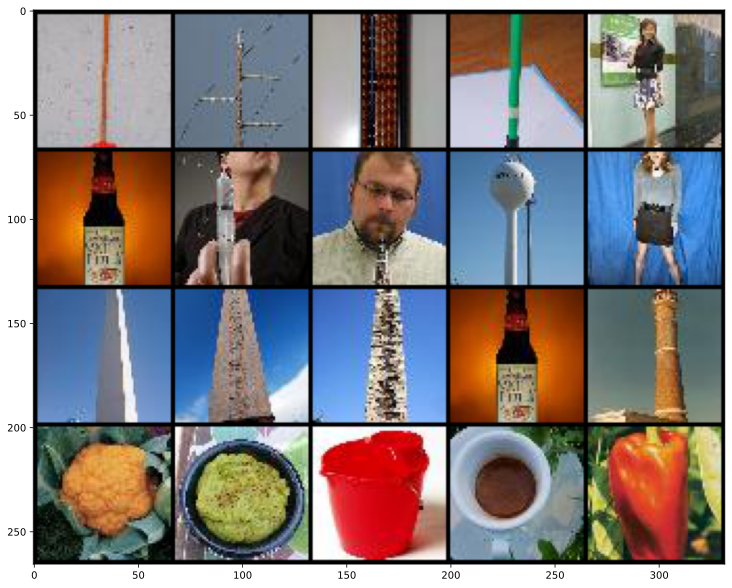

In [211]:
from torchvision.utils import make_grid

Grid = make_grid(top_images, nrow=len(top_images_indices[0]))

img = torchvision.transforms.ToPILImage()(Grid)
plt.figure(figsize=(16, 10))
plt.imshow(img)
plt.show()

Алгоритм видит схожести структур (по примитивам)

Ещё примеры классификации

In [236]:
class_ids = [41, 81, 101, 151]
top_images_indices = []
for class_id in class_ids:
    top_images_indices.append(torch.topk(y_pred[:, class_id], 5))

In [237]:
top_images_indices = [item[1].cpu() for item in top_images_indices]

In [238]:
top_images_indices

[tensor([ 5925, 57552, 18192, 57540, 14012]),
 tensor([40856, 35204, 66905, 40677, 98823]),
 tensor([86584, 86826, 62124, 62420,  5767]),
 tensor([42712, 79387, 67117, 42586, 67268])]

In [239]:
top_images = []
for i in range(len(top_images_indices)):
    images = [image_datasets["train"][idx][0] for idx in top_images_indices[i]]
    top_images += images

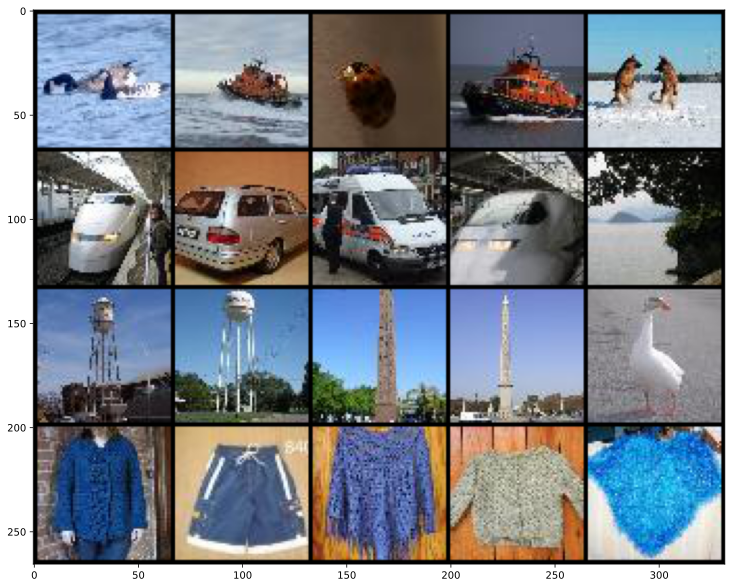

In [240]:
from torchvision.utils import make_grid

Grid = make_grid(top_images, nrow=len(top_images_indices[0]))

img = torchvision.transforms.ToPILImage()(Grid)
plt.figure(figsize=(16, 10))
plt.imshow(img)
plt.show()

В целом довольно неплохо улавливает схожесть структур, да и схожесть самих изображений.